In [1]:
from IPython.core.debugger import set_trace
import itertools
import logging
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st

import os
import pandas as pd
import pickle
import pyabc

import re
from scipy import stats
import seaborn as sns
import tempfile
import theano.tensor as tt

# local
from lib.prior_generation import min_age_prior

### intro

In [2]:
def intro(age, alive, intro_year_before, proba_intro):
    if age < 0 or (age >= 0 and intro_year_before == 0 and alive == 0):
        return 0
      
    if intro_year_before == 1:
        return 1

    return np.random.binomial(n=1, p=proba_intro)    

### age

In [3]:
def age(age_year_before):
    return age_year_before + 1

### alive

In [4]:
def alive(age, alive_last_year, proba_alive):
    if age < 0:
        return 0
    
    if alive_last_year == 0:
        return 0
    
    return np.random.binomial(n=1, p=proba_alive)

### repro_active

In [5]:
def repro_active(age, alive):
    if alive == 0 or age < 9:
        return 0
    else:
        return 1

### birth

In [6]:
def birth(birth_last_year, repro_active, proba_birth):
    if birth_last_year == 1 or repro_active != 1:
        return 0
    
    return np.random.binomial(n=1, p=proba_birth)

### detect

In [7]:
def detect(intro, alive, proba_detect):
    if intro == 0 or alive == 0:
        return 0
    
    return np.random.binomial(n=1, p=proba_detect)

### count

In [8]:
def count(detect, birth):
    if detect == 1 and birth == 1:
        return 2
    elif detect == 1 and birth == 0:
        return 1
    else:
        return 0

In [9]:

sigma = .5

In [10]:
def model(parameters):
    # sample from a gaussian
    y = stats.norm(parameters.x, sigma).rvs()
    # return the sample as dictionary
    return {"y": y}

In [11]:
# We define two models, but they are identical so far
models = [model, model]


# However, our models' priors are not the same.
# Their mean differs.
mu_x_1, mu_x_2 = 0, 1
parameter_priors = [
    pyabc.Distribution(x=pyabc.RV("norm", mu_x_1, sigma)),
    pyabc.Distribution(x=pyabc.RV("norm", mu_x_2, sigma))
]

In [12]:
def distance(x, y):
    return abs(x['y'] - y['y'])

In [13]:
[i for i in reversed(range(11))]

[10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0]

In [14]:

# We plug all the ABC options together
abc = pyabc.ABCSMC(
    models, parameter_priors,
    distance,
    eps=pyabc.ListEpsilon([i for i in reversed(range(11))])
)
    #pyabc.PercentileDistance(measures_to_use=["y"]))



In [15]:
# y_observed is the important piece here: our actual observation.
y_observed = 1
# and we define where to store the results
db_path = ("sqlite:///" +
           os.path.join(tempfile.gettempdir(), "test.db"))
abc_id = abc.new(db_path, {"y": y_observed})


INFO:History:Start <ABCSMC(id=6, start_time=2019-08-27 11:13:13.969210, end_time=None)>


In [17]:

# We run the ABC until either criterion is met
history = abc.run(minimum_epsilon=0.5, max_nr_populations=10)



INFO:ABC:t:0 eps:10
INFO:ABC:t:1 eps:9
INFO:ABC:t:2 eps:8
INFO:ABC:t:3 eps:7
INFO:ABC:t:4 eps:6
INFO:ABC:t:5 eps:5
INFO:ABC:t:6 eps:4
INFO:ABC:t:7 eps:3
INFO:ABC:t:8 eps:2
INFO:ABC:t:9 eps:1
INFO:History:Done <ABCSMC(id=6, start_time=2019-08-27 11:13:13.969210, end_time=2019-08-27 11:13:42.503359)>


In [18]:
# Evaluate the model probabililties
model_probabilities = history.get_model_probabilities()
model_probabilities

m,0,1
t,,
0,0.480000,0.520000
1,0.428382,0.571618
2,0.492288,0.507712
3,0.446792,0.553208
4,0.482455,0.517545
5,0.604750,0.395250
6,0.567104,0.432896
7,0.614419,0.385581
8,0.404452,0.595548


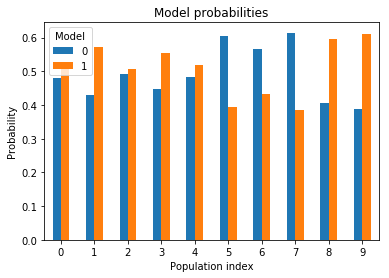

In [19]:
pyabc.visualization.plot_model_probabilities(history)
